In [10]:
%load_ext autoreload
%autoreload 2
import os
import sys
from  partie1 import GRUEncoderGD, GRUDecoderGD
from partie1 import TensorProductEncoder


from partie2 import TPRUEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def generate_data(batch_size, seq_len, min_val=0, max_val=10):
    return torch.randint(min_val, max_val, (batch_size, seq_len))

def precision(predicted, target):
    correct = (predicted.argmax(dim=-1) == target).float()
    return correct.mean().item() * 100

In [4]:
xt = generate_data(5,2)
print(xt.shape)
print(xt)
print(xt[:,1].shape)
print(xt[:,1].unsqueeze(1))

torch.Size([5, 2])
tensor([[9, 4],
        [9, 9],
        [3, 8],
        [8, 8],
        [2, 7]])
torch.Size([5])
tensor([[4],
        [9],
        [8],
        [8],
        [7]])


## Grid search sur nombre fillers par token d'entrée

In [5]:
os.getcwd()

'/Users/lisa.bouger/projet_3A'

In [13]:
input_size = 10
emb_size = 8
hidden_size = 64
output_size = 10

batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.01

# paramètres tpru
d = hidden_size 
d_prime = 1
N = [1,2,4,8,16,32]

os.makedirs("./models/TPRU/GD", exist_ok=True)
os.makedirs("./resultats/TPRU/GD", exist_ok=True)

encoder = GRUEncoderGD(emb_size, hidden_size, output_size, num_layers=1)
encoder = torch.load("./models/GD/gru_enc_emb8_hid64.pth", map_location=torch.device('cpu'))
encoder.eval()

results = []

for n in N : 
    print(f"\n--- N={n} ---\n")
    tpru = TPRUEncoder(d, d_prime, n)
    tpru.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(tpru.parameters(), lr = learning_rate)
    losses=[]
    for epoch in range(epochs):
        data = generate_data(batch_size, seq_len)
        with torch.no_grad():
            _, encoder_hidden = encoder(data)
        encoder_hidden = encoder_hidden[-1, :, :]
        tpru_hidden = tpru(data)
        loss = criterion(encoder_hidden, tpru_hidden)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 2000 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
    torch.save(tpru, f"./models/TPRU/GD/tpru_N{n}.pth")

    plt.figure()
    plt.plot(losses)
    plt.yscale('log')
    plt.title(f'Loss over Epochs (N={n})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(f"./resultats/TPRU/GD/N{n}.png")
    plt.close()

    results.append({
        "N": n,
        "final_loss": losses[-1]
    })

df_results = pd.DataFrame(results)
df_results.to_csv("./resultats/TPRU/GD/grid_search_results_tpru.csv", index=False)



--- N=1 ---

Epoch [2000/10000], Loss: 0.1231
Epoch [4000/10000], Loss: 0.1224
Epoch [6000/10000], Loss: 0.1202
Epoch [8000/10000], Loss: 0.1226
Epoch [10000/10000], Loss: 0.1241

--- N=2 ---

Epoch [2000/10000], Loss: 0.1369
Epoch [4000/10000], Loss: 0.1360
Epoch [6000/10000], Loss: 0.1244
Epoch [8000/10000], Loss: 0.1298
Epoch [10000/10000], Loss: 0.1317

--- N=4 ---

Epoch [2000/10000], Loss: 0.1048
Epoch [4000/10000], Loss: 0.0904
Epoch [6000/10000], Loss: 0.0870
Epoch [8000/10000], Loss: 0.0863
Epoch [10000/10000], Loss: 0.0794

--- N=8 ---

Epoch [2000/10000], Loss: 0.1018
Epoch [4000/10000], Loss: 0.0943
Epoch [6000/10000], Loss: 0.0772
Epoch [8000/10000], Loss: 0.0883
Epoch [10000/10000], Loss: 0.0748

--- N=16 ---

Epoch [2000/10000], Loss: 0.0981
Epoch [4000/10000], Loss: 0.0919
Epoch [6000/10000], Loss: 0.0813
Epoch [8000/10000], Loss: 0.0750
Epoch [10000/10000], Loss: 0.0740

--- N=32 ---

Epoch [2000/10000], Loss: 0.1021
Epoch [4000/10000], Loss: 0.0963
Epoch [6000/10000]

In [29]:
input_size = 10
emb_size = 8
hidden_size = 64
output_size = 10

batch_size = 16
seq_len = 10
epochs = 100000
learning_rate = 0.001

d = hidden_size  #hidden size
d_prime = 1  #chiffre
N = 5  #fillers par chiffre de séquence

encoder = TPRUEncoder(d, d_prime, N)
encoder = torch.load("./models/GD/gru_enc_emb8_hid64.pth")

decoder = GRUDecoderGD(emb_size, hidden_size, output_size)
decoder.load_state_dict(torch.load("./models/tpru_gru_dec.pth"))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []

for epoch in range(epochs):
    x = generate_data(batch_size, seq_len)
    target = x.clone()

    hidden = encoder(x).unsqueeze(0)  
    reconstructed_x = decoder(hidden, seq_len)

    loss = criterion(reconstructed_x.view(-1, output_size), target.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, target)

    losses.append(loss.item())
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

print("Entraînement terminé")

# Sauvegarde des modèles
torch.save(encoder.state_dict(), "./models/tpru_enc.pth")
torch.save(decoder.state_dict(), "./models/tpru_gru_dec.pth")
print("Poids des modèles sauvegardés.")

Epoch [10/100000], Loss: 0.9780, Accuracy: 63.13%
Epoch [20/100000], Loss: 0.8273, Accuracy: 69.38%
Epoch [30/100000], Loss: 0.8646, Accuracy: 68.12%
Epoch [40/100000], Loss: 1.0053, Accuracy: 64.38%
Epoch [50/100000], Loss: 0.8112, Accuracy: 70.63%
Epoch [60/100000], Loss: 0.7973, Accuracy: 70.63%
Epoch [70/100000], Loss: 0.7958, Accuracy: 70.63%
Epoch [80/100000], Loss: 0.7619, Accuracy: 75.63%
Epoch [90/100000], Loss: 0.8735, Accuracy: 66.87%
Epoch [100/100000], Loss: 0.8255, Accuracy: 72.50%
Epoch [110/100000], Loss: 0.9584, Accuracy: 66.25%
Epoch [120/100000], Loss: 0.8815, Accuracy: 68.75%
Epoch [130/100000], Loss: 0.8002, Accuracy: 67.50%
Epoch [140/100000], Loss: 0.8385, Accuracy: 68.75%
Epoch [150/100000], Loss: 0.7967, Accuracy: 73.12%
Epoch [160/100000], Loss: 0.8879, Accuracy: 68.75%
Epoch [170/100000], Loss: 0.8467, Accuracy: 69.38%
Epoch [180/100000], Loss: 0.9138, Accuracy: 65.00%
Epoch [190/100000], Loss: 0.8480, Accuracy: 71.25%
Epoch [200/100000], Loss: 0.8747, Accura

In [26]:
l1 = losses.copy()
a1 = accuracies.copy()

In [30]:
l2 = l1 + losses.copy()
a2 = a1 + accuracies.copy()

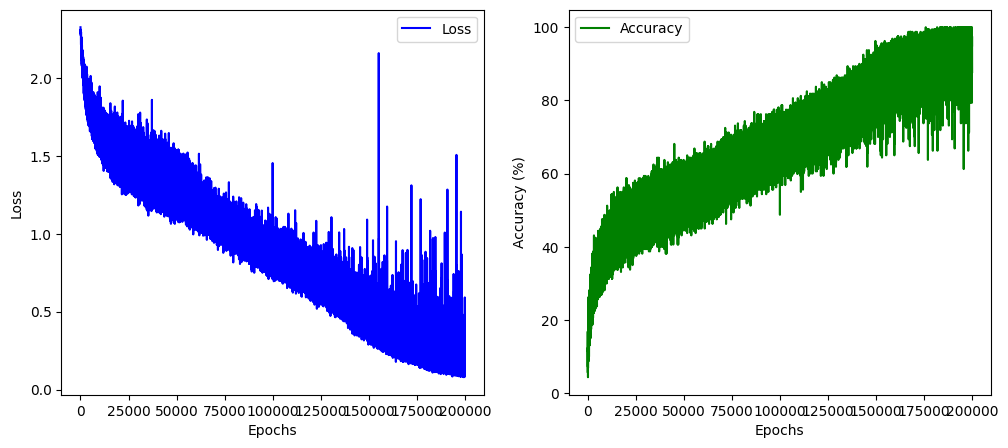

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(l2, label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(a2, label="Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()


In [33]:
import numpy as np

def moving_average(data, window_size=100):
    """
    Applique moyenne glissante à liste de valeurs.
    - window_size : nombre de points considérés pour la moyenne.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
